<a href="https://colab.research.google.com/github/98bao/Migros/blob/main/Kopie_von_Abi_Best_Ac_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
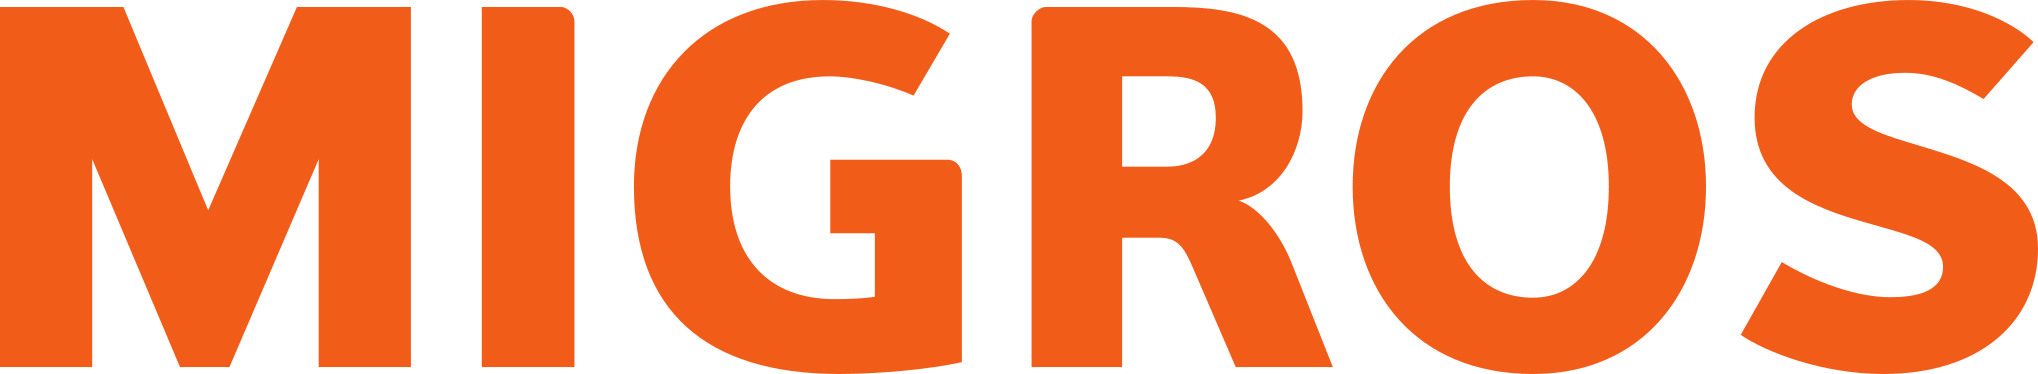
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).


In this first iteration we just fit the training data in the Logistic regression and observe the accuracy.

#Report 📋
  1) At first we submitted a simple logistic regression without data cleaning which gave us a satisfying accuracy of **0.805** on AICrowd
  
  2) We cleaned the text by deleting unecessary elements, then applied a logistic regression with cross validation (LRCV). Although the model built on the train data is pretty good, the accuracy on AICrowd got lower: **0.797**

  3) We used the Random Forest Classifier (RFC) and its model accuracy seemed very promising (0.97 for the train data) however, whilst submitting to AICrowd we got only a result of **0.77**. It seems like we are missing an important point as our accuracy keeps getting lower

#Importing useful tools 🧰

In [1]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [2]:
#clear output
%%capture 
# Install and update spaCy
!pip install -U spacy

!python -m spacy download en
import spacy
from spacy import displacy

In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#clear output
%%capture 

#Importing useful extensions
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

import string
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

#Importing the project dataframes in the notebook 📚
In the following cells, we import some raw dataframes that we are going to use for the project

In [5]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [6]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(5)

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball


In [9]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

#Exploratory data analysis 🕵️

1.   Base rate
2.   List item



####1. Base rate
This indicate how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [10]:
#Base rate of the train df
df_train['target'].value_counts() /len(df_train) 

#The base rate of this dataframe is 0.572

0    0.571936
1    0.428064
Name: target, dtype: float64

In [7]:
#Are there null values ?
print(df_train.text.isnull().sum())
print(df_train.keyword.isnull().sum())

0
55


#Building the tokenizer 🤖
In the following part, we create our tokenizer which will be used to analyze the text column

In [8]:
#Create Tokenizer

#Stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
#Punctuation
punctuations = string.punctuation

sp = spacy.load('en_core_web_sm')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


#Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]  
    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in mytokens]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    # Return preprocessed list of tokens
    return lemma_words

#demo
review = df_train["text"].sample()
review.values[0]


'@FoxNews He still has his beard - has he been visited by any1 while in prison? If he keeps that hideous beard electrocute him! \n#UglyPeople'

In [9]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Logistic regression and pipeline

Our first iteration of the model: *No treatement of the dataframe*, just fitted in a logistic regression to see the result. We submitted this first try on AICrowd to check the accuracy of an uncleaned database.



In [10]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [15]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7ff76485d1e0>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

####Accuracy

In [16]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8924
CONFUSION MATRIX:
[[2873   88]
 [ 469 1746]]


In [17]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7861
CONFUSION MATRIX:
[[653  87]
 [190 365]]


####Using keywords only
This is a test to see if using only the keywords would give a good accuracy

In [ ]:
#Replace null value by an arbitrary string
df_train.keyword.fillna(value = 'nokeyword', inplace = True)

#Verify
df_train.keyword.isnull().sum()

In [ ]:
#Using keyword in the model
features = ['keyword', 'text']

X = df_train['keyword']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])



In [ ]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7f0317681950>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.7407
CONFUSION MATRIX:
[[2339  588]
 [ 737 1445]]


#Data cleaning
To further improve the accuracy of our model, we cleaned the text column by removing unecessary elements such as URL, Tags and noise.

In [11]:
#Clean duplicates
df_train = df_train.drop_duplicates(subset=['text'], keep='first')
df_train = df_train.dropna()


#removing twitter tags
def remove_tags(text):
  text = re.sub(r'@\S+',' ',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))

#replacing "%20" with space
df_train['keyword'] = df_train['keyword'].replace('%20', ' ', regex = True)
df_train['text'] = df_train['text'].replace('%20', ' ', regex = True)

#removing url
def remove_url(text):
  text = re.sub(r'http\S+', ' ', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))

#removing punctuation and numbers and special letters
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))

#removing noises & special characters
def remove_noise(text):
  text = re.sub('RT', ' ', text)
  text = re.sub('rT', ' ', text)
  text = re.sub('Rt', ' ', text)
  text = re.sub('rt', ' ', text)
  text = re.sub('IB', ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('ûª', ' ', text)
  text = re.sub('åê', ' ', text)
  text = re.sub('åÊ', ' ', text)
  text = re.sub('©', ' ', text)
  text = re.sub('û', '', text)
  text = re.sub(' +', ' ', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_noise(x))


df_train['text'] = df_train['text'].str.lower()
df_train['text'].str.strip()

0       black eye a space battle occurred at star o in...
2       reality training train falls off elevated trac...
3       taiwan grace expect that large rocks trees mud...
4       new isis video isis threatens to behead croati...
5       freebesieged ma inmj yougov which tory landsli...
                              ...                        
6459    mt treatment of tigers in china is appalling e...
6464    daily reflections august driven driven by a hu...
6465    chinas stock market crash are there gems in th...
6466    ea hquake sismo m km e of anchorage alaska tim...
6469    friendly reminder that the only country to eve...
Name: text, Length: 4281, dtype: object

In [12]:
#removing twitter tags
def remove_tags(text):
  text = re.sub(r'@\S+',' ',text)
  return text
df_test['text'] = df_test['text'].apply(lambda x: remove_tags(x))

#replacing "%20" with space
df_test['keyword'] = df_test['keyword'].replace('%20', ' ', regex = True)
df_test['text'] = df_test['text'].replace('%20', ' ', regex = True)

#removing url
def remove_url(text):
  text = re.sub(r'http\S+', ' ', text)
  return text
df_test['text'] = df_test['text'].apply(lambda x: remove_url(x))

#removing punctuation
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text
df_test['text'] = df_test['text'].apply(lambda x: remove_punct(x))

#removing noises
def remove_noise(text):
  text = re.sub('RT', ' ', text)
  text = re.sub('rT', ' ', text)
  text = re.sub('Rt', ' ', text)
  text = re.sub('rt', ' ', text)
  text = re.sub('IB', ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('ûª', ' ', text)
  text = re.sub('åê', ' ', text)
  text = re.sub('åÊ', ' ', text)
  text = re.sub('©', ' ', text)
  text = re.sub('û', '', text)
  text = re.sub(' +', ' ', text)
  return text
df_test['text'] = df_test['text'].apply(lambda x: remove_noise(x))

df_test['text'] = df_test['text'].str.lower()
df_test['text'].str.rstrip()

0       crptotech tsunami and banks banking tech bitco...
1       im that traumatised that i cant even spell pro...
2        so where are the rioters looters and burning ...
3                       me watching law amp order vine by
4                       papi absolutely crushed that ball
                              ...                        
1137     im at work its a bunch of ppl and buses becau...
1138     suicide bomber kills in saudi security site m...
1139    eruption of indonesian volcano sparks transpo ...
1140    never let fear get in the way of achieving you...
1141     wowo nigerian refugees repatriated from cameroon
Name: text, Length: 1142, dtype: object

#Using different classifiers

We tried different classifier to know which one could predict the best our model

##Logistic regression with cross validation

In [ ]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Logistic regressin cross validation
from sklearn.linear_model import LogisticRegressionCV
LRCV = LRCV = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000, random_state=123)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LRCV)])



In [ ]:
#Fit
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<function spacy_tokenizer at 0x7f0317681950>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=5,
                                      dual=Fal

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9313
CONFUSION MATRIX:
[[2856   71]
 [ 280 1902]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7825
CONFUSION MATRIX:
[[645 104]
 [174 355]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
sample_submission.target = target_test
sample_submission.to_csv('submission-2.csv', index=False)

##Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Define classifier
RFC = RandomForestClassifier(n_estimators = 10)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])

In [ ]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9728
CONFUSION MATRIX:
[[2904   23]
 [ 116 2066]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7621
CONFUSION MATRIX:
[[655  94]
 [210 319]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
sample_submission.target = target_test
sample_submission.to_csv('submission-4.csv', index=False)

##Doc2Vec

In [14]:
text = df_train['text']
text.head(5)
text.to_csv('text.csv')
from google.colab import files
files.download('text.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
#Tokenize data
sample_tagged = df_train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)
print(sample_tagged.head(20))

0     ([black, eye, space, battl, occur, star, o, in...
2     ([realiti, train, train, fall, elev, track, wi...
3     ([taiwan, grace, expect, larg, rock, tree, mud...
4     ([new, isi, video, isi, threaten, behead, croa...
5     ([freebesieg, ma, inmj, yougov, tori, landslid...
6     ([billionair, plan, free, half, billion, dolla...
7     ([old, testimoni, weapon, use, promot, conflic...
8     ([ali, fli, plane, run, burn, build, soup, man...
10              ([polic, monitor, jihadi, poland], [1])
11    ([dad, panic, weight, loss, mean, need, hurri,...
12    ([alleg, driver, kuwait, attack, join, daesh, ...
13    ([video, fire, burn, apa, ment, build, blow, c...
16    ([god, forbid, famili, know, answer, phone, ne...
17    ([micom, summer, contrast, candi, color, bowkn...
18    ([abc, news, polic, offic, wound, suspect, dea...
19    ([reddit, new, content, polici, effect, horrib...
22    ([usual, d, agre, chop, head, throw, gay, roof...
23    ([fire, hazard, associ, instal, noncompli,

In [16]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=72)

In [18]:
#Define Doc2Vec and build vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epoch=300)
model_dbow.build_vocab([x for x in train_tagged.values])

In [19]:
#Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [20]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [21]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))
print(f"CONFUSION MATRIX Test:\n{confusion_matrix(y_test, y_pred)}")

0.776
CONFUSION MATRIX Test:
[[419  66]
 [126 246]]


In [50]:
y_pred_train = logreg.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX Train:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9019
CONFUSION MATRIX Train:
[[1761   97]
 [ 215 1109]]


##Bag of Words

In [ ]:
def remove_stopwords(text):
  text_n = ""
  for word in text:
    if word not in stop_words:
      
      text_n = text_n + word
  return text_n

df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))


In [ ]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



In [ ]:
count = CountVectorizer(ngram_range=(1,2),stop_words="english")
bow = count.fit_transform(df_train['text'])
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
bow_train

,aa,aa batteries,aa near,aaaa,aaaa ok,aaaaaaallll,aaaaaaallll ûªm,aaaaaand,aaaaaand theres,aaarrrgghhh,aal,aampb,aampb pipeliners,aampw,aampw pmclose,aan,aan den,aannnnd,aannnnd reddit,aar,aar ambulancewe,aashiqui,aashiqui actress,ab,ab resin,aba,aba woman,abandon,abandon plans,abandon west,abandoned,abandoned aircraft,abandoned cabin,abandoned cocker,abandoned station,abandoning,abandoning deal,abbandoned,abbandoned sinking,abbott,...,ûò lovefood,ûò malaysian,ûò musicians,ûò news,ûò pa,ûò public,ûò residents,ûò skyåênews,ûò steve,ûò usa,ûò video,ûò vladimir,ûò ûïdetonate,ûòthe,ûòthe united,ûòåêcnbc,ûó,ûó athlete,ûó britain,ûó bulletproof,ûó eh,ûó head,ûó hiroshimanagasaki,ûó integrates,ûó lol,ûó news,ûó officials,ûó oh,ûó organizers,ûó richmond,ûó stories,ûó ûªm,ûóbbc,ûóbbc looks,ûóher,ûóher upper,ûókody,ûókody vine,ûónegligence,ûónegligence fireworks
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5895,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5896,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Submission 👀
This is the code that we use to create the submission. To use it, we can just copy/paste it below the classifier of our choice and rename the .csv file.

In [51]:
df_test['target'] = np.zeros

In [61]:
sample_tagged = df_test.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)
print(sample_tagged.head(20))

1     ([traumatis, spell, properli, excus, typo], [<...
4     ([papi, absolut, crush, ball], [<built-in func...
6     ([twitsandiego, possibl, sinkhol, disrupt, tro...
8     ([kessler, syndrom, catastroph, exponenti, pro...
9     ([train, derail, instead, work, earli, like, l...
10    ([new, evacu, order, home, danger, hwi, fire, ...
11    ([bbcnew, ass, british, insur, riot, cost, ins...
13    ([littl, piec, write, avalanch, design, blog, ...
15    ([let, s, talk, goof, guild, saunder, come, ri...
16    ([kelbi, tomlinson, mildmanner, nd, baseman, g...
17    ([join, chariti, k, run, event, sta, sun, sept...
19    ([ahh, forget, headphon, suppos, surviv, day, ...
20    ([uncl, wreck, shit], [<built-in function zero...
21    ([eu, state, squabbl, immigr, ukfranc, eurotun...
22    ([japan, resta, nuclear, reactor, fleet, fast,...
24    ([total, agre, rape, kill, destroy, leav, land...
25    ([fire, pisgah, nation, forest, grow, acr], [<...
26    ([s, fire, alarm, zehr, work, minut, decid

In [62]:

y_target, X_target = vec_for_learning(model_dbow, sample_tagged)

In [63]:
target_test = logreg.predict(X_target)

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [64]:
sample_submission['target'] = target_test
sample_submission.head(5)

ValueError: ignored

In [ ]:

sample_submission['target'].to_csv('submission-11.csv',index=False)

In [ ]:
from google.colab import files
files.download('submission-11.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>